# 🏗️🧪 Pipeline de Nettoyage Personnalisable

## 📋 Objectifs de ce Notebook

Dans ce notebook, nous allons construire un **système de pipeline modulaire** pour le nettoyage de texte, permettant de configurer et optimiser le preprocessing selon vos besoins.

### 🎯 Ce que vous allez apprendre :
- ✅ Créer un pipeline modulaire avec des étapes configurables
- ✅ Traiter de gros volumes de données efficacement
- ✅ Mesurer la qualité du nettoyage avec des métriques
- ✅ Visualiser et comparer différentes configurations
- ✅ Optimiser les performances pour la production
- ✅ Créer des rapports de nettoyage automatisés

### ⏱️ Durée estimée : 60-75 minutes
### 🎯 Niveau : Intermédiaire à Avancé

---

## 📦 Imports et Configuration

Importons tous les modules nécessaires pour notre pipeline :

In [1]:
import re
import time
import unicodedata
import json
from typing import List, Dict, Callable, Optional, Any, Tuple
from dataclasses import dataclass
from collections import Counter, defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("tab10")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("✅ Imports terminés !")
print("🏗️ Prêt pour construire des pipelines de nettoyage !")

✅ Imports terminés !
🏗️ Prêt pour construire des pipelines de nettoyage !


## 🤔 Pourquoi un Pipeline Modulaire ?

Avant de construire notre solution, comprenons les limitations d'une approche monolithique :

In [2]:
# Exemple d'approche monolithique (problématique)
def nettoyage_monolithique(texte):
    """Approche monolithique - difficile à maintenir et adapter"""
    # Tout dans une seule fonction = inflexible
    texte = texte.lower()
    texte = re.sub(r'https?://[^\s]+', '', texte)
    texte = re.sub(r'@\w+', '', texte)
    texte = re.sub(r'#\w+', '', texte)
    texte = re.sub(r'[^\w\s]', ' ', texte)
    texte = re.sub(r'\s+', ' ', texte).strip()
    return texte

print("❌ Problèmes de l'approche monolithique:")
print("   • Impossible de désactiver une étape spécifique")
print("   • Difficile de tester individuellement chaque transformation")
print("   • Pas de métriques sur l'impact de chaque étape")
print("   • Code dupliqué si on veut des variantes")
print("   • Difficile d'optimiser ou de déboguer")

print("\n✅ Avantages d'un pipeline modulaire:")
print("   • Chaque étape est une fonction indépendante")
print("   • Configuration flexible (activer/désactiver des étapes)")
print("   • Tests unitaires par étape")
print("   • Métriques détaillées sur chaque transformation")
print("   • Réutilisabilité et maintenabilité")
print("   • Facilite le debugging et l'optimisation")

❌ Problèmes de l'approche monolithique:
   • Impossible de désactiver une étape spécifique
   • Difficile de tester individuellement chaque transformation
   • Pas de métriques sur l'impact de chaque étape
   • Code dupliqué si on veut des variantes
   • Difficile d'optimiser ou de déboguer

✅ Avantages d'un pipeline modulaire:
   • Chaque étape est une fonction indépendante
   • Configuration flexible (activer/désactiver des étapes)
   • Tests unitaires par étape
   • Métriques détaillées sur chaque transformation
   • Réutilisabilité et maintenabilité
   • Facilite le debugging et l'optimisation


## 🏗️ Architecture du Pipeline Modulaire

Créons d'abord les structures de données pour notre pipeline :

In [3]:
@dataclass
class EtapeMetrics:
    """Métriques pour une étape du pipeline"""
    nom_etape: str
    temps_execution: float
    textes_traites: int
    caracteres_avant: int
    caracteres_apres: int
    mots_avant: int
    mots_apres: int
    erreurs: int = 0
    
    @property
    def reduction_caracteres(self) -> float:
        return (self.caracteres_avant - self.caracteres_apres) / self.caracteres_avant if self.caracteres_avant > 0 else 0
    
    @property
    def reduction_mots(self) -> float:
        return (self.mots_avant - self.mots_apres) / self.mots_avant if self.mots_avant > 0 else 0
    
    @property
    def vitesse(self) -> float:
        return self.textes_traites / self.temps_execution if self.temps_execution > 0 else 0

@dataclass
class PipelineConfig:
    """Configuration du pipeline"""
    nom: str
    description: str
    etapes_actives: List[str]
    parametres: Dict[str, Any]
    version: str = "1.0"
    
    def to_dict(self) -> Dict:
        return {
            'nom': self.nom,
            'description': self.description,
            'etapes_actives': self.etapes_actives,
            'parametres': self.parametres,
            'version': self.version
        }

class EtapePipeline:
    """Classe de base pour une étape du pipeline"""
    
    def __init__(self, nom: str, description: str, actif: bool = True):
        self.nom = nom
        self.description = description
        self.actif = actif
        self.parametres = {}
    
    def traiter(self, texte: str) -> str:
        """Méthode à implémenter dans les sous-classes"""
        raise NotImplementedError
    
    def valider_entree(self, texte: str) -> bool:
        """Valide que l'entrée est correcte"""
        return isinstance(texte, str)
    
    def configurer(self, **kwargs):
        """Configure les paramètres de l'étape"""
        self.parametres.update(kwargs)
        return self

print("✅ Structures de base créées !")
print("🏗️ Architecture modulaire prête !")

✅ Structures de base créées !
🏗️ Architecture modulaire prête !


## 🔧 Création des Étapes de Nettoyage

Implémentons toutes les étapes de nettoyage comme des modules indépendants :

In [4]:
class EtapeMinuscules(EtapePipeline):
    """Convertit le texte en minuscules"""
    
    def __init__(self):
        super().__init__("minuscules", "Conversion en minuscules")
    
    def traiter(self, texte: str) -> str:
        return texte.lower()

class EtapeSuppressionURLs(EtapePipeline):
    """Supprime les URLs"""
    
    def __init__(self):
        super().__init__("suppression_urls", "Suppression des URLs et liens")
        self.pattern = re.compile(r'https?://[^\s]+|www\.[^\s]+', re.IGNORECASE)
        self.parametres = {'remplacement': ' '}
    
    def traiter(self, texte: str) -> str:
        return self.pattern.sub(self.parametres['remplacement'], texte)

class EtapeSuppressionEmails(EtapePipeline):
    """Supprime les adresses email"""
    
    def __init__(self):
        super().__init__("suppression_emails", "Suppression des adresses email")
        self.pattern = re.compile(r'\S+@\S+\.\S+')
        self.parametres = {'remplacement': ' '}
    
    def traiter(self, texte: str) -> str:
        return self.pattern.sub(self.parametres['remplacement'], texte)

class EtapeSuppressionMentions(EtapePipeline):
    """Supprime les mentions @utilisateur"""
    
    def __init__(self):
        super().__init__("suppression_mentions", "Suppression des mentions @utilisateur")
        self.pattern = re.compile(r'@\w+')
        self.parametres = {'remplacement': ' '}
    
    def traiter(self, texte: str) -> str:
        return self.pattern.sub(self.parametres['remplacement'], texte)

class EtapeSuppressionHashtags(EtapePipeline):
    """Supprime les hashtags #mot"""
    
    def __init__(self):
        super().__init__("suppression_hashtags", "Suppression des hashtags #mot")
        self.pattern = re.compile(r'#\w+')
        self.parametres = {'remplacement': ' '}
    
    def traiter(self, texte: str) -> str:
        return self.pattern.sub(self.parametres['remplacement'], texte)

class EtapeSuppressionPonctuation(EtapePipeline):
    """Supprime la ponctuation"""
    
    def __init__(self):
        super().__init__("suppression_ponctuation", "Suppression de la ponctuation")
        self.parametres = {
            'garder_accents': True,
            'remplacement': ' '
        }
    
    def traiter(self, texte: str) -> str:
        if self.parametres['garder_accents']:
            # Garde les lettres accentuées françaises
            pattern = r'[^\w\sàâäéèêëïîôöùûüÿç]'
        else:
            pattern = r'[^\w\s]'
        
        return re.sub(pattern, self.parametres['remplacement'], texte)

class EtapeSuppressionChiffres(EtapePipeline):
    """Supprime les chiffres"""
    
    def __init__(self):
        super().__init__("suppression_chiffres", "Suppression des chiffres")
        self.pattern = re.compile(r'\d+')
        self.parametres = {'remplacement': ' '}
    
    def traiter(self, texte: str) -> str:
        return self.pattern.sub(self.parametres['remplacement'], texte)

class EtapeNormalisationEspaces(EtapePipeline):
    """Normalise les espaces multiples"""
    
    def __init__(self):
        super().__init__("normalisation_espaces", "Normalisation des espaces multiples")
        self.pattern = re.compile(r'\s+')
    
    def traiter(self, texte: str) -> str:
        return self.pattern.sub(' ', texte).strip()

class EtapeSuppressionAccents(EtapePipeline):
    """Supprime les accents"""
    
    def __init__(self):
        super().__init__("suppression_accents", "Suppression des accents")
    
    def traiter(self, texte: str) -> str:
        # Normalisation NFD puis suppression des diacritiques
        texte_nfd = unicodedata.normalize('NFD', texte)
        texte_sans_accents = ''.join(c for c in texte_nfd if unicodedata.category(c) != 'Mn')
        return unicodedata.normalize('NFC', texte_sans_accents)

class EtapeFiltreLongueur(EtapePipeline):
    """Filtre les mots trop courts ou trop longs"""
    
    def __init__(self):
        super().__init__("filtre_longueur", "Filtrage par longueur de mots")
        self.parametres = {
            'longueur_min': 2,
            'longueur_max': 20
        }
    
    def traiter(self, texte: str) -> str:
        mots = texte.split()
        mots_filtres = [
            mot for mot in mots 
            if self.parametres['longueur_min'] <= len(mot) <= self.parametres['longueur_max']
        ]
        return ' '.join(mots_filtres)

print("✅ Étapes de nettoyage créées !")
print(f"🔧 {10} étapes modulaires disponibles !")

✅ Étapes de nettoyage créées !
🔧 10 étapes modulaires disponibles !


## 🏭 Classe Pipeline Principale

Maintenant, créons la classe principale qui orchestre toutes les étapes :

In [5]:
class PipelineNettoyage:
    """Pipeline modulaire et configurable pour le nettoyage de texte"""
    
    def __init__(self, nom: str = "Pipeline Personnalisé"):
        self.nom = nom
        self.etapes_disponibles = {
            'minuscules': EtapeMinuscules(),
            'suppression_urls': EtapeSuppressionURLs(),
            'suppression_emails': EtapeSuppressionEmails(),
            'suppression_mentions': EtapeSuppressionMentions(),
            'suppression_hashtags': EtapeSuppressionHashtags(),
            'suppression_ponctuation': EtapeSuppressionPonctuation(),
            'suppression_chiffres': EtapeSuppressionChiffres(),
            'suppression_accents': EtapeSuppressionAccents(),
            'filtre_longueur': EtapeFiltreLongueur(),
            'normalisation_espaces': EtapeNormalisationEspaces()
        }
        
        # Ordre par défaut des étapes (optimisé)
        self.ordre_etapes = [
            'suppression_urls',
            'suppression_emails', 
            'suppression_mentions',
            'suppression_hashtags',
            'minuscules',
            'suppression_accents',
            'suppression_ponctuation',
            'suppression_chiffres',
            'normalisation_espaces',
            'filtre_longueur'
        ]
        
        self.metrics_historique = []
        self.config_actuelle = None
    
    def configurer_etape(self, nom_etape: str, **parametres) -> 'PipelineNettoyage':
        """Configure les paramètres d'une étape spécifique"""
        if nom_etape in self.etapes_disponibles:
            self.etapes_disponibles[nom_etape].configurer(**parametres)
        return self
    
    def activer_etapes(self, etapes: List[str]) -> 'PipelineNettoyage':
        """Active uniquement les étapes spécifiées"""
        # Désactive toutes les étapes
        for etape in self.etapes_disponibles.values():
            etape.actif = False
        
        # Active les étapes demandées
        for nom_etape in etapes:
            if nom_etape in self.etapes_disponibles:
                self.etapes_disponibles[nom_etape].actif = True
        
        return self
    
    def desactiver_etapes(self, etapes: List[str]) -> 'PipelineNettoyage':
        """Désactive les étapes spécifiées"""
        for nom_etape in etapes:
            if nom_etape in self.etapes_disponibles:
                self.etapes_disponibles[nom_etape].actif = False
        return self
    
    def definir_ordre(self, ordre: List[str]) -> 'PipelineNettoyage':
        """Définit l'ordre d'exécution des étapes"""
        # Vérifier que toutes les étapes existent
        etapes_valides = [e for e in ordre if e in self.etapes_disponibles]
        self.ordre_etapes = etapes_valides
        return self
    
    def traiter_texte(self, texte: str, avec_metriques: bool = True) -> Tuple[str, List[EtapeMetrics]]:
        """Traite un seul texte et retourne le résultat avec métriques"""
        if not isinstance(texte, str):
            return "", []
        
        resultat = texte
        metriques = []
        
        for nom_etape in self.ordre_etapes:
            etape = self.etapes_disponibles[nom_etape]
            
            if not etape.actif:
                continue
            
            # Mesures avant traitement
            texte_avant = resultat
            chars_avant = len(texte_avant)
            mots_avant = len(texte_avant.split())
            
            # Traitement avec mesure du temps
            start_time = time.time()
            try:
                if etape.valider_entree(resultat):
                    resultat = etape.traiter(resultat)
                    erreurs = 0
                else:
                    erreurs = 1
            except Exception as e:
                print(f"Erreur dans l'étape {nom_etape}: {e}")
                erreurs = 1
            
            end_time = time.time()
            
            # Mesures après traitement
            chars_apres = len(resultat)
            mots_apres = len(resultat.split())
            
            # Création des métriques
            if avec_metriques:
                metric = EtapeMetrics(
                    nom_etape=nom_etape,
                    temps_execution=end_time - start_time,
                    textes_traites=1,
                    caracteres_avant=chars_avant,
                    caracteres_apres=chars_apres,
                    mots_avant=mots_avant,
                    mots_apres=mots_apres,
                    erreurs=erreurs
                )
                metriques.append(metric)
        
        return resultat, metriques
    
    def traiter_batch(self, textes: List[str], taille_batch: int = 100) -> Tuple[List[str], List[EtapeMetrics]]:
        """Traite un batch de textes avec métriques agrégées"""
        resultats = []
        metriques_globales = defaultdict(lambda: {
            'temps_total': 0,
            'textes_traites': 0,
            'chars_avant_total': 0,
            'chars_apres_total': 0,
            'mots_avant_total': 0,
            'mots_apres_total': 0,
            'erreurs_total': 0
        })
        
        print(f"🚀 Traitement de {len(textes)} textes par batches de {taille_batch}...")
        
        for i in range(0, len(textes), taille_batch):
            batch = textes[i:i+taille_batch]
            
            for texte in batch:
                resultat, metriques_texte = self.traiter_texte(texte, avec_metriques=True)
                resultats.append(resultat)
                
                # Agrégation des métriques
                for metric in metriques_texte:
                    m = metriques_globales[metric.nom_etape]
                    m['temps_total'] += metric.temps_execution
                    m['textes_traites'] += 1
                    m['chars_avant_total'] += metric.caracteres_avant
                    m['chars_apres_total'] += metric.caracteres_apres
                    m['mots_avant_total'] += metric.mots_avant
                    m['mots_apres_total'] += metric.mots_apres
                    m['erreurs_total'] += metric.erreurs
            
            if (i // taille_batch + 1) % 10 == 0:
                print(f"   📊 Traité {i + len(batch)} textes...")
        
        # Création des métriques finales
        metriques_finales = []
        for nom_etape, stats in metriques_globales.items():
            if stats['textes_traites'] > 0:
                metric = EtapeMetrics(
                    nom_etape=nom_etape,
                    temps_execution=stats['temps_total'],
                    textes_traites=stats['textes_traites'],
                    caracteres_avant=stats['chars_avant_total'],
                    caracteres_apres=stats['chars_apres_total'],
                    mots_avant=stats['mots_avant_total'],
                    mots_apres=stats['mots_apres_total'],
                    erreurs=stats['erreurs_total']
                )
                metriques_finales.append(metric)
        
        self.metrics_historique.extend(metriques_finales)
        
        print(f"✅ Traitement terminé ! {len(resultats)} textes traités.")
        return resultats, metriques_finales
    
    def obtenir_config(self) -> PipelineConfig:
        """Retourne la configuration actuelle du pipeline"""
        etapes_actives = [nom for nom, etape in self.etapes_disponibles.items() if etape.actif]
        parametres = {nom: etape.parametres for nom, etape in self.etapes_disponibles.items()}
        
        return PipelineConfig(
            nom=self.nom,
            description=f"Pipeline avec {len(etapes_actives)} étapes actives",
            etapes_actives=etapes_actives,
            parametres=parametres
        )
    
    def sauvegarder_config(self, fichier: str):
        """Sauvegarde la configuration dans un fichier JSON"""
        config = self.obtenir_config()
        with open(fichier, 'w', encoding='utf-8') as f:
            json.dump(config.to_dict(), f, indent=2, ensure_ascii=False)
        print(f"💾 Configuration sauvegardée dans {fichier}")
    
    def charger_config(self, fichier: str):
        """Charge une configuration depuis un fichier JSON"""
        with open(fichier, 'r', encoding='utf-8') as f:
            config_dict = json.load(f)
        
        self.nom = config_dict['nom']
        self.activer_etapes(config_dict['etapes_actives'])
        
        # Charge les paramètres
        for nom_etape, params in config_dict['parametres'].items():
            if nom_etape in self.etapes_disponibles:
                self.etapes_disponibles[nom_etape].parametres.update(params)
        
        print(f"📥 Configuration chargée depuis {fichier}")
    
    def __str__(self) -> str:
        etapes_actives = [nom for nom, etape in self.etapes_disponibles.items() if etape.actif]
        return f"Pipeline '{self.nom}' avec {len(etapes_actives)} étapes actives: {etapes_actives}"

print("✅ Classe PipelineNettoyage créée !")
print("🏭 Pipeline modulaire opérationnel !")

✅ Classe PipelineNettoyage créée !
🏭 Pipeline modulaire opérationnel !


## 🧪 Test du Pipeline avec Différentes Configurations

Testons notre pipeline avec plusieurs configurations prédéfinies :

In [15]:
# Données de test variées
textes_test = [
    "J'ADORE ce produit 😍 ! Contactez-moi à user@email.com pour plus d'infos #génial",
    "Service client TERRIBLE 😡 ! URL: https://site-arnaque.com @service_client #déçu", 
    "Bon produit mais cher... 🤔 Prix: 199.99€ livraison en 24h !!! #correct",
    "PARFAIT !!! Exactement ce que je cherchais 🎉 merci @vendeur https://shop.fr",
    "Très déçu de mon achat 😞 qualité pas au rendez-vous pour 50€ #arnaque",
    "Recommande vivement !!! 5 étoiles ⭐⭐⭐⭐⭐ contact: info@boutique.fr"
]

print(f"📝 Dataset de test: {len(textes_test)} textes")
print("\n🔍 Textes originaux:")
for i, texte in enumerate(textes_test, 1):
    print(f"   {i}. {texte}")

# Configuration 1: Nettoyage minimal
print("\n" + "="*60)
print("🔧 CONFIGURATION 1: Nettoyage Minimal")
print("="*60)

pipeline_minimal = PipelineNettoyage("Minimal")
pipeline_minimal.activer_etapes([
    'minuscules',
    'normalisation_espaces'
])

print(f"📋 {pipeline_minimal}")

resultats_minimal, metriques_minimal = pipeline_minimal.traiter_batch(textes_test)

print("\n📊 Résultats:")
for i, (original, resultat) in enumerate(zip(textes_test, resultats_minimal), 1):
    print(f"   {i}. {resultat}")

# Configuration 2: Nettoyage standard e-commerce
print("\n" + "="*60)
print("🔧 CONFIGURATION 2: Nettoyage E-commerce Standard")
print("="*60)

pipeline_ecommerce = PipelineNettoyage("E-commerce")
pipeline_ecommerce.activer_etapes([
    'suppression_urls',
    'suppression_emails',
    'suppression_mentions',
    'suppression_hashtags',
    'minuscules',
    'suppression_ponctuation',
    'normalisation_espaces'
])

# Configuration spéciale: garder les accents
pipeline_ecommerce.configurer_etape('suppression_ponctuation', garder_accents=True)

print(f"📋 {pipeline_ecommerce}")

resultats_ecommerce, metriques_ecommerce = pipeline_ecommerce.traiter_batch(textes_test)

print("\n📊 Résultats:")
for i, (original, resultat) in enumerate(zip(textes_test, resultats_ecommerce), 1):
    print(f"   {i}. {resultat}")

# Configuration 3: Nettoyage agressif pour recherche
print("\n" + "="*60)
print("🔧 CONFIGURATION 3: Nettoyage Agressif (Recherche)")
print("="*60)

pipeline_recherche = PipelineNettoyage("Recherche")
pipeline_recherche.activer_etapes([
    'suppression_urls',
    'suppression_emails',
    'suppression_mentions',
    'suppression_hashtags',
    'minuscules',
    'suppression_accents',
    'suppression_ponctuation',
    'suppression_chiffres',
    'filtre_longueur',
    'normalisation_espaces'
])

# Configuration: mots de 3+ caractères
pipeline_recherche.configurer_etape('filtre_longueur', longueur_min=3, longueur_max=15)

print(f"📋 {pipeline_recherche}")

resultats_recherche, metriques_recherche = pipeline_recherche.traiter_batch(textes_test)

print("\n📊 Résultats:")
for i, (original, resultat) in enumerate(zip(textes_test, resultats_recherche), 1):
    print(f"   {i}. {resultat}")

📝 Dataset de test: 6 textes

🔍 Textes originaux:
   1. J'ADORE ce produit 😍 ! Contactez-moi à user@email.com pour plus d'infos #génial
   2. Service client TERRIBLE 😡 ! URL: https://site-arnaque.com @service_client #déçu
   3. Bon produit mais cher... 🤔 Prix: 199.99€ livraison en 24h !!! #correct
   4. PARFAIT !!! Exactement ce que je cherchais 🎉 merci @vendeur https://shop.fr
   5. Très déçu de mon achat 😞 qualité pas au rendez-vous pour 50€ #arnaque
   6. Recommande vivement !!! 5 étoiles ⭐⭐⭐⭐⭐ contact: info@boutique.fr

🔧 CONFIGURATION 1: Nettoyage Minimal
📋 Pipeline 'Minimal' avec 2 étapes actives: ['minuscules', 'normalisation_espaces']
🚀 Traitement de 6 textes par batches de 100...
✅ Traitement terminé ! 6 textes traités.

📊 Résultats:
   1. j'adore ce produit 😍 ! contactez-moi à user@email.com pour plus d'infos #génial
   2. service client terrible 😡 ! url: https://site-arnaque.com @service_client #déçu
   3. bon produit mais cher... 🤔 prix: 199.99€ livraison en 24h !!! #correct

## 📊 Analyse des Métriques et Visualisations

Analysons les performances et l'impact de chaque configuration :

In [7]:
# Fonction pour analyser les métriques
def analyser_metriques(metriques: List[EtapeMetrics], nom_config: str):
    """Analyse et affiche les métriques d'une configuration"""
    print(f"\n📊 ANALYSE MÉTRIQUES - {nom_config.upper()}")
    print("-" * 50)
    
    temps_total = sum(m.temps_execution for m in metriques)
    chars_avant_total = sum(m.caracteres_avant for m in metriques)
    chars_apres_total = sum(m.caracteres_apres for m in metriques)
    mots_avant_total = sum(m.mots_avant for m in metriques)
    mots_apres_total = sum(m.mots_apres for m in metriques)
    
    print(f"⏱️ Temps total: {temps_total:.4f}s")
    print(f"📏 Réduction caractères: {chars_avant_total} → {chars_apres_total} ({((chars_avant_total-chars_apres_total)/chars_avant_total)*100:.1f}%)")
    print(f"📝 Réduction mots: {mots_avant_total} → {mots_apres_total} ({((mots_avant_total-mots_apres_total)/mots_avant_total)*100:.1f}%)")
    print(f"⚡ Vitesse globale: {len(textes_test)/temps_total:.0f} textes/seconde")
    
    print("\n🔍 Détail par étape:")
    for metric in metriques:
        print(f"   {metric.nom_etape:25} | {metric.temps_execution*1000:6.2f}ms | "
              f"{metric.reduction_caracteres*100:5.1f}% chars | {metric.reduction_mots*100:5.1f}% mots")

# Analyse des trois configurations
analyser_metriques(metriques_minimal, "Minimal")
analyser_metriques(metriques_ecommerce, "E-commerce")
analyser_metriques(metriques_recherche, "Recherche")

# Préparation des données pour visualisation
configs_data = {
    'Minimal': metriques_minimal,
    'E-commerce': metriques_ecommerce,
    'Recherche': metriques_recherche
}

# Création des DataFrames pour analyse
df_comparaison = []
for config_nom, metriques in configs_data.items():
    temps_total = sum(m.temps_execution for m in metriques)
    chars_reduction = sum(m.caracteres_avant - m.caracteres_apres for m in metriques) / sum(m.caracteres_avant for m in metriques) * 100
    mots_reduction = sum(m.mots_avant - m.mots_apres for m in metriques) / sum(m.mots_avant for m in metriques) * 100
    vitesse = len(textes_test) / temps_total
    
    df_comparaison.append({
        'Configuration': config_nom,
        'Temps (ms)': temps_total * 1000,
        'Réduction Chars (%)': chars_reduction,
        'Réduction Mots (%)': mots_reduction,
        'Vitesse (textes/s)': vitesse,
        'Nb Étapes': len(metriques)
    })

df_comp = pd.DataFrame(df_comparaison)
print("\n📈 Tableau comparatif:")
print(df_comp.to_string(index=False))


📊 ANALYSE MÉTRIQUES - MINIMAL
--------------------------------------------------
⏱️ Temps total: 0.0000s
📏 Réduction caractères: 874 → 874 (0.0%)
📝 Réduction mots: 130 → 130 (0.0%)
⚡ Vitesse globale: 267722 textes/seconde

🔍 Détail par étape:
   minuscules                |   0.00ms |   0.0% chars |   0.0% mots
   normalisation_espaces     |   0.02ms |   0.0% chars |   0.0% mots

📊 ANALYSE MÉTRIQUES - E-COMMERCE
--------------------------------------------------
⏱️ Temps total: 0.0001s
📏 Réduction caractères: 2541 → 2371 (6.7%)
📝 Réduction mots: 407 → 391 (3.9%)
⚡ Vitesse globale: 57986 textes/seconde

🔍 Détail par étape:
   suppression_urls          |   0.01ms |   8.5% chars |   3.1% mots
   suppression_emails        |   0.02ms |   7.0% chars |   3.2% mots
   suppression_mentions      |   0.00ms |   5.6% chars |   3.3% mots
   suppression_hashtags      |   0.01ms |   6.8% chars |   6.8% mots
   minuscules                |   0.00ms |   0.0% chars |   0.0% mots
   suppression_ponctuatio

## 📈 Visualisations Comparatives

Créons des graphiques pour mieux comprendre l'impact de chaque configuration :

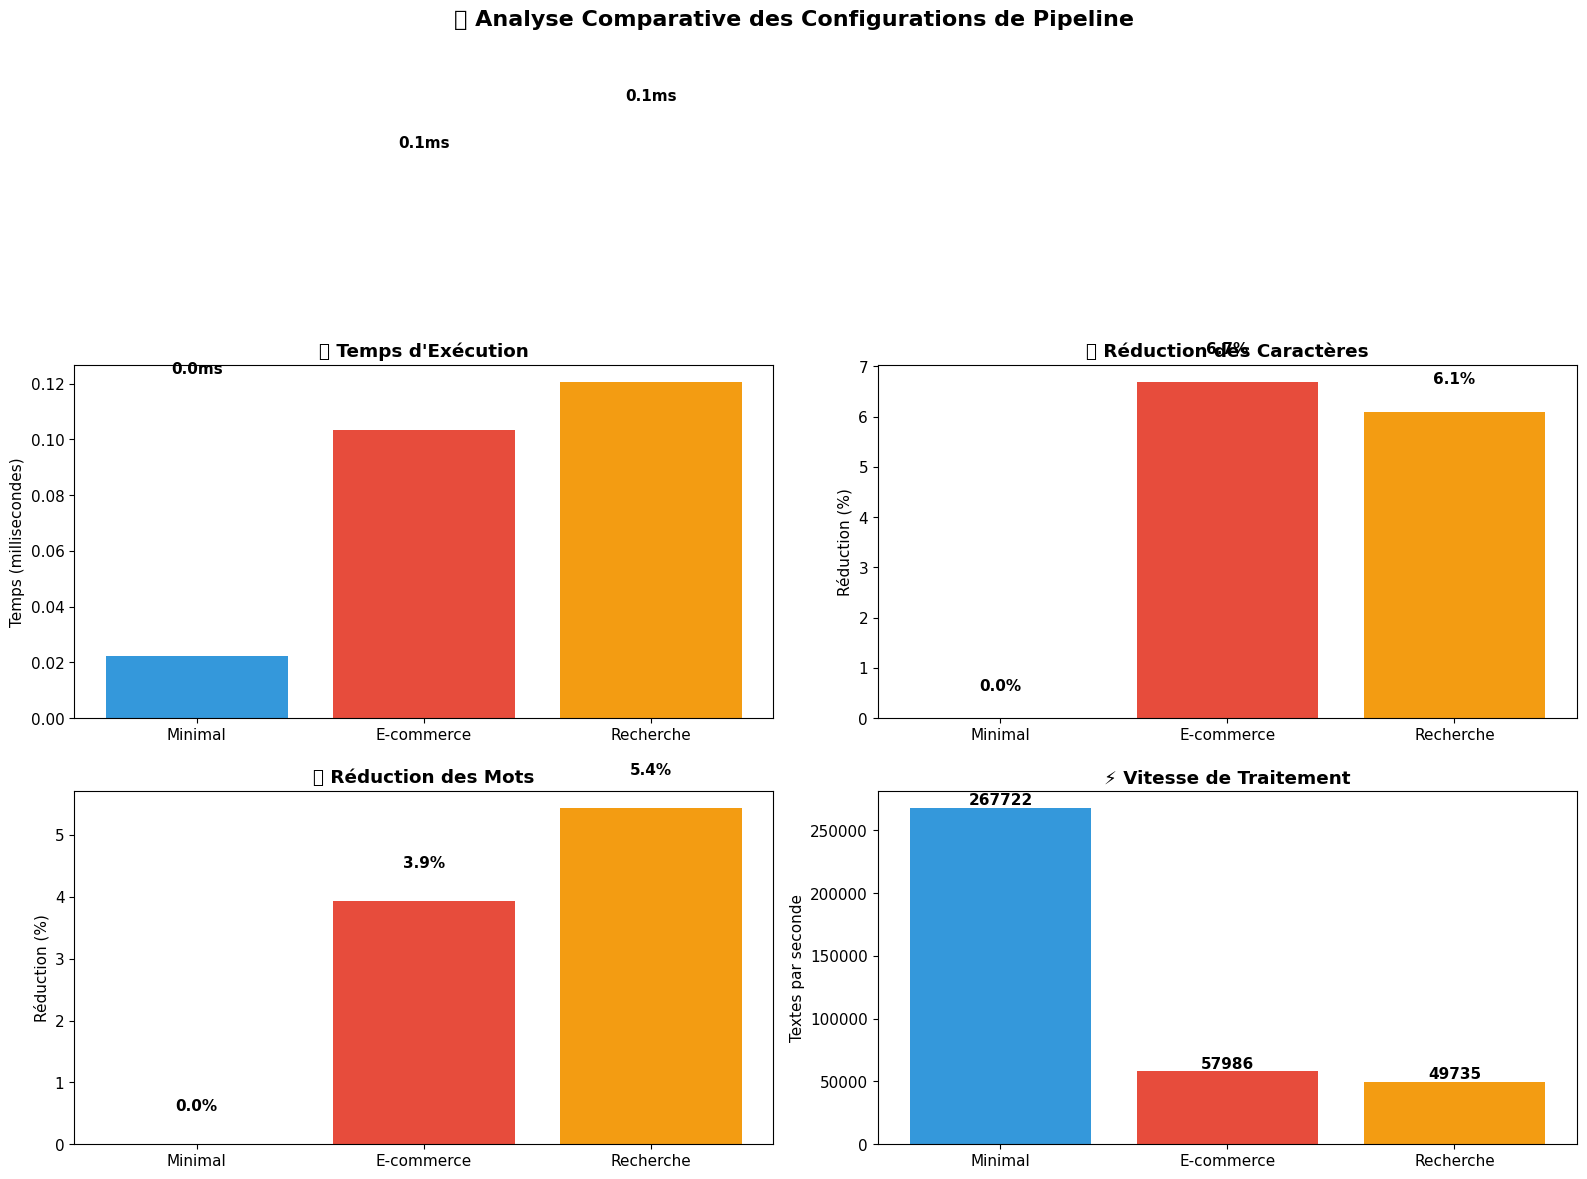

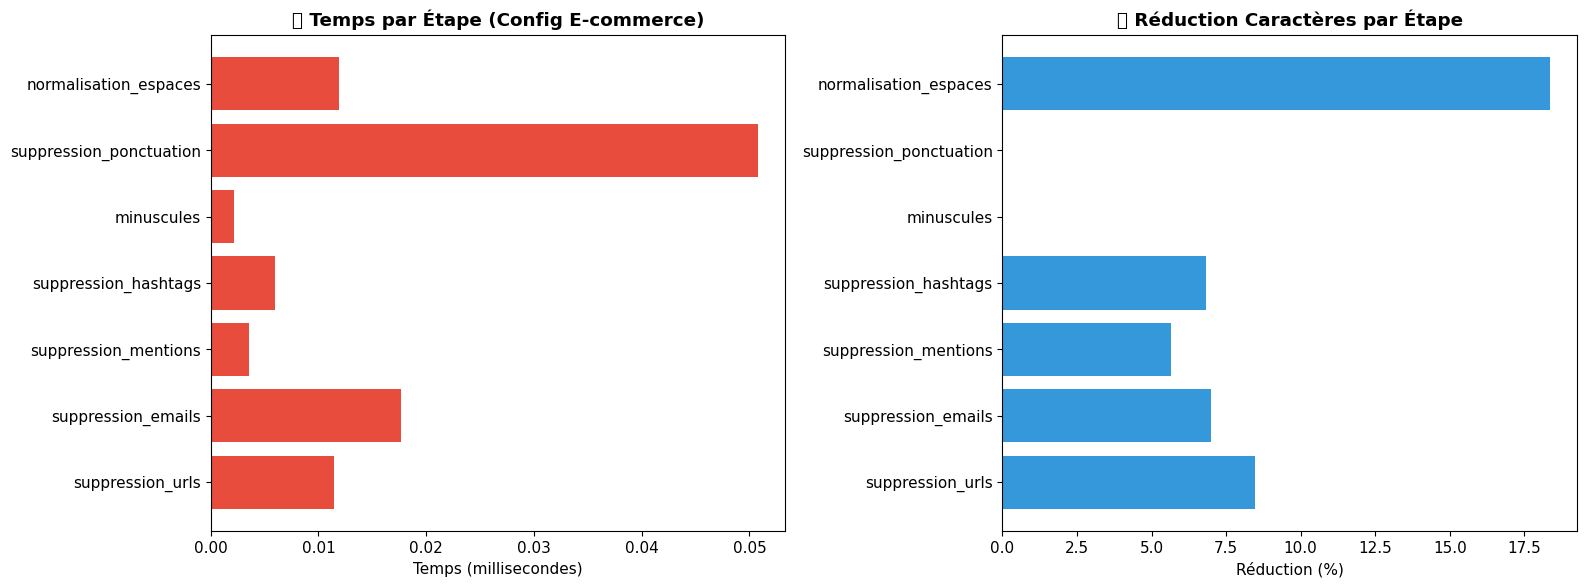

📊 Graphiques générés avec succès !


In [8]:
# Graphiques comparatifs
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('🔍 Analyse Comparative des Configurations de Pipeline', fontsize=16, fontweight='bold')

# 1. Temps d'exécution
colors = ['#3498db', '#e74c3c', '#f39c12']
bars1 = ax1.bar(df_comp['Configuration'], df_comp['Temps (ms)'], color=colors)
ax1.set_title('⏱️ Temps d\'Exécution', fontweight='bold')
ax1.set_ylabel('Temps (millisecondes)')
for bar, temps in zip(bars1, df_comp['Temps (ms)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{temps:.1f}ms', ha='center', va='bottom', fontweight='bold')

# 2. Réduction des caractères
bars2 = ax2.bar(df_comp['Configuration'], df_comp['Réduction Chars (%)'], color=colors)
ax2.set_title('📏 Réduction des Caractères', fontweight='bold')
ax2.set_ylabel('Réduction (%)')
for bar, reduction in zip(bars2, df_comp['Réduction Chars (%)']):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{reduction:.1f}%', ha='center', va='bottom', fontweight='bold')

# 3. Réduction des mots
bars3 = ax3.bar(df_comp['Configuration'], df_comp['Réduction Mots (%)'], color=colors)
ax3.set_title('📝 Réduction des Mots', fontweight='bold')
ax3.set_ylabel('Réduction (%)')
for bar, reduction in zip(bars3, df_comp['Réduction Mots (%)']):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
             f'{reduction:.1f}%', ha='center', va='bottom', fontweight='bold')

# 4. Vitesse de traitement
bars4 = ax4.bar(df_comp['Configuration'], df_comp['Vitesse (textes/s)'], color=colors)
ax4.set_title('⚡ Vitesse de Traitement', fontweight='bold')
ax4.set_ylabel('Textes par seconde')
for bar, vitesse in zip(bars4, df_comp['Vitesse (textes/s)']):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10,
             f'{vitesse:.0f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Graphique détaillé par étape
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Temps par étape pour la config e-commerce
etapes_noms = [m.nom_etape for m in metriques_ecommerce]
etapes_temps = [m.temps_execution * 1000 for m in metriques_ecommerce]

ax1.barh(etapes_noms, etapes_temps, color='#e74c3c')
ax1.set_title('⏱️ Temps par Étape (Config E-commerce)', fontweight='bold')
ax1.set_xlabel('Temps (millisecondes)')

# Réduction par étape
etapes_reduction = [m.reduction_caracteres * 100 for m in metriques_ecommerce]

ax2.barh(etapes_noms, etapes_reduction, color='#3498db')
ax2.set_title('📏 Réduction Caractères par Étape', fontweight='bold')
ax2.set_xlabel('Réduction (%)')

plt.tight_layout()
plt.show()

print("📊 Graphiques générés avec succès !")

## ⚡ Test de Performance sur Gros Volume

Testons les performances sur un dataset plus important :

In [9]:
import random

# Génération d'un dataset plus important
def generer_dataset_test(taille=1000):
    """Génère un dataset de test avec du contenu varié"""
    modeles = [
        "Produit EXCELLENT 😍 ! Je recommande vivement @boutique #satisfaction",
        "Service client décevant 😞 contact@service.com ne répond pas #problème",
        "Très bon rapport qualité/prix 👍 livraison rapide https://shop.fr",
        "ARNAQUE !!! Fuyez ce site 😡 prix trop élevé pour la qualité #arnaque",
        "Correct sans plus... 🤔 ça peut aller mais pas exceptionnel",
        "PARFAIT !!! Exactement ce que je cherchais ⭐⭐⭐⭐⭐ merci !",
        "Livraison en retard 📦 mais produit conforme à la description",
        "Super équipe 🎉 service après-vente au top ! contact: info@help.fr",
        "Prix un peu cher 💰 mais qualité au rendez-vous 👌 #qualité",
        "Site web mal conçu 💻 difficile de naviguer https://badsite.com"
    ]
    
    textes = []
    for _ in range(taille):
        base = random.choice(modeles)
        # Variations aléatoires
        if random.random() < 0.3:
            base += f" {random.choice(['!!!', '???', '...', ' SUPER', ' NUL'])}"
        if random.random() < 0.2:
            base = base.upper()  # Parfois tout en majuscules
        textes.append(base)
    
    return textes

# Génération du dataset
print("🔄 Génération du dataset de test...")
dataset_large = generer_dataset_test(2000)
print(f"✅ Dataset généré: {len(dataset_large)} textes")
print(f"📝 Exemple: {dataset_large[0]}")

# Test de performance des 3 configurations
print("\n🚀 TEST DE PERFORMANCE - GROS VOLUME")
print("=" * 50)

configs_test = {
    'Minimal': pipeline_minimal,
    'E-commerce': pipeline_ecommerce,
    'Recherche': pipeline_recherche
}

resultats_perf = {}

for nom_config, pipeline in configs_test.items():
    print(f"\n📊 Test de {nom_config}...")
    
    start_time = time.time()
    resultats, metriques = pipeline.traiter_batch(dataset_large, taille_batch=200)
    end_time = time.time()
    
    temps_total = end_time - start_time
    vitesse = len(dataset_large) / temps_total
    
    # Calcul des statistiques
    chars_avant = sum(m.caracteres_avant for m in metriques)
    chars_apres = sum(m.caracteres_apres for m in metriques)
    mots_avant = sum(m.mots_avant for m in metriques)
    mots_apres = sum(m.mots_apres for m in metriques)
    
    resultats_perf[nom_config] = {
        'temps_total': temps_total,
        'vitesse': vitesse,
        'reduction_chars': (chars_avant - chars_apres) / chars_avant * 100,
        'reduction_mots': (mots_avant - mots_apres) / mots_avant * 100,
        'nb_etapes': len(metriques),
        'chars_avant': chars_avant,
        'chars_apres': chars_apres
    }
    
    print(f"   ⏱️ Temps: {temps_total:.2f}s")
    print(f"   ⚡ Vitesse: {vitesse:.0f} textes/seconde")
    print(f"   📏 Réduction chars: {resultats_perf[nom_config]['reduction_chars']:.1f}%")
    print(f"   📝 Réduction mots: {resultats_perf[nom_config]['reduction_mots']:.1f}%")

# Résumé comparatif
print("\n📈 RÉSUMÉ COMPARATIF")
print("=" * 50)

df_perf = pd.DataFrame([
    {
        'Configuration': nom,
        'Temps (s)': stats['temps_total'],
        'Vitesse (textes/s)': stats['vitesse'],
        'Réduction Chars (%)': stats['reduction_chars'],
        'Réduction Mots (%)': stats['reduction_mots'],
        'Nb Étapes': stats['nb_etapes']
    }
    for nom, stats in resultats_perf.items()
])

print(df_perf.to_string(index=False, float_format='%.1f'))

# Recommandations basées sur les résultats
print("\n💡 RECOMMANDATIONS:")
vitesse_max = df_perf['Vitesse (textes/s)'].max()
config_plus_rapide = df_perf.loc[df_perf['Vitesse (textes/s)'].idxmax(), 'Configuration']

reduction_max = df_perf['Réduction Chars (%)'].max()
config_plus_efficace = df_perf.loc[df_perf['Réduction Chars (%)'].idxmax(), 'Configuration']

print(f"   🏎️ Plus rapide: {config_plus_rapide} ({vitesse_max:.0f} textes/s)")
print(f"   🎯 Plus efficace: {config_plus_efficace} ({reduction_max:.1f}% de réduction)")
print(f"   ⚖️ Équilibré: E-commerce (bon compromis vitesse/nettoyage)")

🔄 Génération du dataset de test...
✅ Dataset généré: 2000 textes
📝 Exemple: Site web mal conçu 💻 difficile de naviguer https://badsite.com  SUPER

🚀 TEST DE PERFORMANCE - GROS VOLUME

📊 Test de Minimal...
🚀 Traitement de 2000 textes par batches de 200...
   📊 Traité 2000 textes...
✅ Traitement terminé ! 2000 textes traités.
   ⏱️ Temps: 0.01s
   ⚡ Vitesse: 183366 textes/seconde
   📏 Réduction chars: 0.1%
   📝 Réduction mots: 0.0%

📊 Test de E-commerce...
🚀 Traitement de 2000 textes par batches de 200...
   📊 Traité 2000 textes...
✅ Traitement terminé ! 2000 textes traités.
   ⏱️ Temps: 0.03s
   ⚡ Vitesse: 59880 textes/seconde
   📏 Réduction chars: 4.3%
   📝 Réduction mots: 3.6%

📊 Test de Recherche...
🚀 Traitement de 2000 textes par batches de 200...
   📊 Traité 2000 textes...
✅ Traitement terminé ! 2000 textes traités.
   ⏱️ Temps: 0.05s
   ⚡ Vitesse: 37564 textes/seconde
   📏 Réduction chars: 3.8%
   📝 Réduction mots: 4.2%

📈 RÉSUMÉ COMPARATIF
Configuration  Temps (s)  Vitesse (texte

## 🛠️ Configurateur Interactif de Pipeline

Créons un outil pour configurer facilement votre pipeline personnalisé :

In [10]:
class ConfigurateurPipeline:
    """Outil interactif pour configurer des pipelines"""
    
    def __init__(self):
        self.configurations_predefinies = {
            'minimal': {
                'nom': 'Minimal',
                'description': 'Nettoyage de base - préserve le maximum d\'information',
                'etapes': ['minuscules', 'normalisation_espaces'],
                'cas_usage': 'Prototypage, tests rapides'
            },
            'ecommerce': {
                'nom': 'E-commerce',
                'description': 'Optimisé pour l\'analyse d\'avis clients',
                'etapes': ['suppression_urls', 'suppression_emails', 'suppression_mentions', 
                          'suppression_hashtags', 'minuscules', 'suppression_ponctuation', 
                          'normalisation_espaces'],
                'cas_usage': 'Analyse de sentiment, avis clients'
            },
            'recherche': {
                'nom': 'Recherche',
                'description': 'Nettoyage agressif pour la recherche d\'information',
                'etapes': ['suppression_urls', 'suppression_emails', 'suppression_mentions',
                          'suppression_hashtags', 'minuscules', 'suppression_accents',
                          'suppression_ponctuation', 'suppression_chiffres', 
                          'filtre_longueur', 'normalisation_espaces'],
                'cas_usage': 'Moteur de recherche, classification'
            },
            'social_media': {
                'nom': 'Réseaux Sociaux',
                'description': 'Adapté aux contenus de réseaux sociaux',
                'etapes': ['suppression_urls', 'minuscules', 'suppression_ponctuation',
                          'normalisation_espaces'],
                'cas_usage': 'Analyse de tweets, posts Facebook'
            },
            'academique': {
                'nom': 'Académique',
                'description': 'Pour les textes formels et académiques',
                'etapes': ['minuscules', 'suppression_ponctuation', 'suppression_chiffres',
                          'filtre_longueur', 'normalisation_espaces'],
                'cas_usage': 'Articles scientifiques, documents formels'
            }
        }
    
    def afficher_configurations(self):
        """Affiche toutes les configurations disponibles"""
        print("🔧 CONFIGURATIONS PRÉDÉFINIES")
        print("=" * 50)
        
        for cle, config in self.configurations_predefinies.items():
            print(f"\n📋 {config['nom'].upper()} ({cle})")
            print(f"   📝 Description: {config['description']}")
            print(f"   🎯 Cas d'usage: {config['cas_usage']}")
            print(f"   🔧 Étapes ({len(config['etapes'])}): {', '.join(config['etapes'])}")
    
    def creer_pipeline(self, config_nom: str) -> PipelineNettoyage:
        """Crée un pipeline basé sur une configuration prédéfinie"""
        if config_nom not in self.configurations_predefinies:
            raise ValueError(f"Configuration '{config_nom}' non trouvée")
        
        config = self.configurations_predefinies[config_nom]
        pipeline = PipelineNettoyage(config['nom'])
        pipeline.activer_etapes(config['etapes'])
        
        # Configurations spéciales par type
        if config_nom == 'ecommerce':
            pipeline.configurer_etape('suppression_ponctuation', garder_accents=True)
        elif config_nom == 'recherche':
            pipeline.configurer_etape('filtre_longueur', longueur_min=3, longueur_max=15)
        elif config_nom == 'academique':
            pipeline.configurer_etape('filtre_longueur', longueur_min=4, longueur_max=20)
        
        return pipeline
    
    def tester_configurations(self, textes_test: List[str]):
        """Teste toutes les configurations sur un échantillon"""
        print(f"🧪 TEST DE TOUTES LES CONFIGURATIONS")
        print(f"📊 Dataset: {len(textes_test)} textes")
        print("=" * 70)
        
        resultats_comparaison = []
        
        for config_nom in self.configurations_predefinies.keys():
            print(f"\n🔧 Test de {config_nom}...")
            
            # Création et test du pipeline
            pipeline = self.creer_pipeline(config_nom)
            resultats, metriques = pipeline.traiter_batch(textes_test)
            
            # Calcul des statistiques
            chars_avant = sum(m.caracteres_avant for m in metriques)
            chars_apres = sum(m.caracteres_apres for m in metriques)
            mots_avant = sum(m.mots_avant for m in metriques)
            mots_apres = sum(m.mots_apres for m in metriques)
            temps_total = sum(m.temps_execution for m in metriques)
            
            stats = {
                'Configuration': self.configurations_predefinies[config_nom]['nom'],
                'Nb Étapes': len(metriques),
                'Temps (ms)': temps_total * 1000,
                'Réduction Chars (%)': (chars_avant - chars_apres) / chars_avant * 100 if chars_avant > 0 else 0,
                'Réduction Mots (%)': (mots_avant - mots_apres) / mots_avant * 100 if mots_avant > 0 else 0,
                'Vitesse (textes/s)': len(textes_test) / temps_total if temps_total > 0 else 0
            }
            
            resultats_comparaison.append(stats)
            
            # Affichage d'un exemple
            if textes_test:
                print(f"   📝 Exemple: {textes_test[0][:50]}...")
                print(f"   ✨ Résultat: {resultats[0][:50]}...")
        
        # Tableau comparatif final
        print("\n📊 TABLEAU COMPARATIF FINAL")
        print("=" * 70)
        df_final = pd.DataFrame(resultats_comparaison)
        print(df_final.to_string(index=False, float_format='%.1f'))
        
        return df_final

# Création et test du configurateur
configurateur = ConfigurateurPipeline()

print("🛠️ CONFIGURATEUR DE PIPELINE CRÉÉ !")
configurateur.afficher_configurations()

🛠️ CONFIGURATEUR DE PIPELINE CRÉÉ !
🔧 CONFIGURATIONS PRÉDÉFINIES

📋 MINIMAL (minimal)
   📝 Description: Nettoyage de base - préserve le maximum d'information
   🎯 Cas d'usage: Prototypage, tests rapides
   🔧 Étapes (2): minuscules, normalisation_espaces

📋 E-COMMERCE (ecommerce)
   📝 Description: Optimisé pour l'analyse d'avis clients
   🎯 Cas d'usage: Analyse de sentiment, avis clients
   🔧 Étapes (7): suppression_urls, suppression_emails, suppression_mentions, suppression_hashtags, minuscules, suppression_ponctuation, normalisation_espaces

📋 RECHERCHE (recherche)
   📝 Description: Nettoyage agressif pour la recherche d'information
   🎯 Cas d'usage: Moteur de recherche, classification
   🔧 Étapes (10): suppression_urls, suppression_emails, suppression_mentions, suppression_hashtags, minuscules, suppression_accents, suppression_ponctuation, suppression_chiffres, filtre_longueur, normalisation_espaces

📋 RÉSEAUX SOCIAUX (social_media)
   📝 Description: Adapté aux contenus de réseaux so

## 🧪 Exercice Pratique : Votre Pipeline Personnalisé

À votre tour ! Créez et testez votre propre configuration :

In [11]:
# 🎯 EXERCICE: Créez votre pipeline personnalisé

print("🎯 EXERCICE PRATIQUE: Créez Votre Pipeline")
print("=" * 50)

# Scénario: Vous analysez des commentaires de blog français
# Les commentaires contiennent des URLs, des mentions, mais vous voulez garder
# les hashtags car ils indiquent les sujets traités

commentaires_blog = [
    "Excellent article ! 👍 Merci @auteur pour ces conseils #utile https://blog.fr",
    "Pas d'accord avec cette approche... 🤔 trop simpliste #débat @expert",
    "SUPER BLOG !!! Je partage sur Facebook 📱 #partage contact@admin.fr",
    "Article intéressant mais manque d'exemples concrets #critique #amélioration",
    "Merci pour ce tuto étape par étape ! 🙏 Très clair #tutorial #apprentissage",
    "Source pas fiable... 😒 vérifiez vos infos SVP #factcheck https://verify.com"
]

print("📝 Scénario: Analyse de commentaires de blog français")
print("🎯 Objectifs:")
print("   • Garder les hashtags (sujets importants)")
print("   • Supprimer URLs et emails (bruit)")
print("   • Garder les accents français")
print("   • Gérer les emojis (convertir ou supprimer ?)")
print("   • Optimiser pour l'analyse de contenu")

print("\n📊 Commentaires à analyser:")
for i, comment in enumerate(commentaires_blog, 1):
    print(f"   {i}. {comment}")

# TODO: Créez votre configuration personnalisée
print("\n🔧 Créez votre pipeline:")

# Étape 1: Créez votre pipeline
mon_pipeline = PipelineNettoyage("Blog Comments Analyzer")

# Étape 2: Choisissez vos étapes (décommentez celles que vous voulez)
etapes_choisies = [
    'suppression_urls',        # ✅ Recommandé
    'suppression_emails',      # ✅ Recommandé  
    'suppression_mentions',    # ❓ À vous de décider
    # 'suppression_hashtags',  # ❌ Pas recommandé (info importante)
    'minuscules',             # ✅ Recommandé
    # 'suppression_accents',   # ❓ Français = garder les accents ?
    'suppression_ponctuation', # ✅ Recommandé
    # 'suppression_chiffres',  # ❓ Les chiffres sont-ils importants ?
    'normalisation_espaces',   # ✅ Toujours recommandé
    # 'filtre_longueur'        # ❓ Selon vos besoins
]

# Activation des étapes
mon_pipeline.activer_etapes(etapes_choisies)

# Étape 3: Configuration des paramètres
mon_pipeline.configurer_etape('suppression_ponctuation', garder_accents=True)
# mon_pipeline.configurer_etape('filtre_longueur', longueur_min=3, longueur_max=15)

print(f"✅ Pipeline créé: {mon_pipeline}")

# Étape 4: Test de votre pipeline
print("\n🧪 Test de votre configuration:")

mes_resultats, mes_metriques = mon_pipeline.traiter_batch(commentaires_blog)

print("\n📊 Résultats:")
for i, (original, resultat) in enumerate(zip(commentaires_blog, mes_resultats), 1):
    print(f"\n{i}. Original: {original}")
    print(f"   Nettoyé:  {resultat}")
    print(f"   Mots: {len(original.split())} → {len(resultat.split())}")

# Étape 5: Analyse de votre configuration
print("\n📈 Analyse de votre pipeline:")
analyser_metriques(mes_metriques, "Votre Configuration")

# Questions d'évaluation
print("\n🤔 Questions d'évaluation:")
print("   1. Les hashtags sont-ils préservés ? (Important pour identifier les sujets)")
print("   2. Les accents français sont-ils gardés ? (Qualité de la langue)")
print("   3. Le nettoyage supprime-t-il le bruit sans perdre le sens ?")
print("   4. Les résultats sont-ils exploitables pour l'analyse de contenu ?")
print("   5. Le pipeline est-il assez rapide pour traiter de gros volumes ?")

# Sauvegarde de votre configuration
print("\n💾 Sauvegarde de votre configuration:")
# mon_pipeline.sauvegarder_config('ma_config_blog.json')
print("📋 Configuration actuelle:")
config = mon_pipeline.obtenir_config()
print(f"   Nom: {config.nom}")
print(f"   Étapes actives: {config.etapes_actives}")

🎯 EXERCICE PRATIQUE: Créez Votre Pipeline
📝 Scénario: Analyse de commentaires de blog français
🎯 Objectifs:
   • Garder les hashtags (sujets importants)
   • Supprimer URLs et emails (bruit)
   • Garder les accents français
   • Gérer les emojis (convertir ou supprimer ?)
   • Optimiser pour l'analyse de contenu

📊 Commentaires à analyser:
   1. Excellent article ! 👍 Merci @auteur pour ces conseils #utile https://blog.fr
   2. Pas d'accord avec cette approche... 🤔 trop simpliste #débat @expert
   3. SUPER BLOG !!! Je partage sur Facebook 📱 #partage contact@admin.fr
   4. Article intéressant mais manque d'exemples concrets #critique #amélioration
   5. Merci pour ce tuto étape par étape ! 🙏 Très clair #tutorial #apprentissage
   6. Source pas fiable... 😒 vérifiez vos infos SVP #factcheck https://verify.com

🔧 Créez votre pipeline:
✅ Pipeline créé: Pipeline 'Blog Comments Analyzer' avec 6 étapes actives: ['minuscules', 'suppression_urls', 'suppression_emails', 'suppression_mentions', 'su

## 🔄 Comparaison avec Configurations Prédéfinies

Comparons votre configuration avec les configurations prédéfinies :

In [12]:
# Test de toutes les configurations sur les commentaires de blog
print("⚔️ COMPARAISON AVEC CONFIGURATIONS PRÉDÉFINIES")
print("=" * 60)

# Test du configurateur
df_comparaison_final = configurateur.tester_configurations(commentaires_blog)

# Ajout de votre configuration aux résultats
chars_avant_total = sum(m.caracteres_avant for m in mes_metriques)
chars_apres_total = sum(m.caracteres_apres for m in mes_metriques)
mots_avant_total = sum(m.mots_avant for m in mes_metriques)
mots_apres_total = sum(m.mots_apres for m in mes_metriques)
temps_total = sum(m.temps_execution for m in mes_metriques)

votre_config = {
    'Configuration': 'VOTRE CONFIG',
    'Nb Étapes': len(mes_metriques),
    'Temps (ms)': temps_total * 1000,
    'Réduction Chars (%)': (chars_avant_total - chars_apres_total) / chars_avant_total * 100 if chars_avant_total > 0 else 0,
    'Réduction Mots (%)': (mots_avant_total - mots_apres_total) / mots_avant_total * 100 if mots_avant_total > 0 else 0,
    'Vitesse (textes/s)': len(commentaires_blog) / temps_total if temps_total > 0 else 0
}

# Ajout à la comparaison
df_avec_votre_config = pd.concat([
    df_comparaison_final,
    pd.DataFrame([votre_config])
], ignore_index=True)

print("\n🏆 CLASSEMENT FINAL (avec votre configuration):")
print("=" * 60)
print(df_avec_votre_config.to_string(index=False, float_format='%.1f'))

# Analyse de votre position
votre_rang_vitesse = (df_avec_votre_config['Vitesse (textes/s)'] > votre_config['Vitesse (textes/s)']).sum() + 1
votre_rang_efficacite = (df_avec_votre_config['Réduction Chars (%)'] > votre_config['Réduction Chars (%)']).sum() + 1

print(f"\n🎯 Position de votre configuration:")
print(f"   ⚡ Vitesse: {votre_rang_vitesse}e position sur {len(df_avec_votre_config)}")
print(f"   🎯 Efficacité: {votre_rang_efficacite}e position sur {len(df_avec_votre_config)}")

# Recommandations personnalisées
print("\n💡 Recommandations pour votre cas d'usage (blog):")
if 'suppression_hashtags' not in etapes_choisies:
    print("   ✅ Bon choix : hashtags préservés (sujets importants)")
else:
    print("   ⚠️ Attention : hashtags supprimés (perte d'info sur les sujets)")

if votre_config['Réduction Chars (%)'] > 30:
    print("   ✅ Bon nettoyage : suppression efficace du bruit")
elif votre_config['Réduction Chars (%)'] < 15:
    print("   ⚠️ Nettoyage léger : peut-être trop conservateur")

if votre_config['Vitesse (textes/s)'] > 1000:
    print("   ✅ Performance excellente : adapté aux gros volumes")
elif votre_config['Vitesse (textes/s)'] < 500:
    print("   ⚠️ Performance modérée : optimiser pour la production")

⚔️ COMPARAISON AVEC CONFIGURATIONS PRÉDÉFINIES
🧪 TEST DE TOUTES LES CONFIGURATIONS
📊 Dataset: 6 textes

🔧 Test de minimal...
🚀 Traitement de 6 textes par batches de 100...
✅ Traitement terminé ! 6 textes traités.
   📝 Exemple: Excellent article ! 👍 Merci @auteur pour ces conse...
   ✨ Résultat: excellent article ! 👍 merci @auteur pour ces conse...

🔧 Test de ecommerce...
🚀 Traitement de 6 textes par batches de 100...
✅ Traitement terminé ! 6 textes traités.
   📝 Exemple: Excellent article ! 👍 Merci @auteur pour ces conse...
   ✨ Résultat: excellent article merci pour ces conseils...

🔧 Test de recherche...
🚀 Traitement de 6 textes par batches de 100...
✅ Traitement terminé ! 6 textes traités.
   📝 Exemple: Excellent article ! 👍 Merci @auteur pour ces conse...
   ✨ Résultat: excellent article merci pour ces conseils...

🔧 Test de social_media...
🚀 Traitement de 6 textes par batches de 100...
✅ Traitement terminé ! 6 textes traités.
   📝 Exemple: Excellent article ! 👍 Merci @auteur pour 

## 📊 Rapport de Nettoyage Automatisé

Générons un rapport complet pour documenter nos analyses :

In [13]:
def generer_rapport_nettoyage(pipeline: PipelineNettoyage, 
                            textes_originaux: List[str], 
                            textes_nettoyes: List[str],
                            metriques: List[EtapeMetrics]) -> str:
    """Génère un rapport détaillé du nettoyage"""
    
    config = pipeline.obtenir_config()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    # Calculs statistiques
    chars_avant_total = sum(len(t) for t in textes_originaux)
    chars_apres_total = sum(len(t) for t in textes_nettoyes)
    mots_avant_total = sum(len(t.split()) for t in textes_originaux)
    mots_apres_total = sum(len(t.split()) for t in textes_nettoyes)
    temps_total = sum(m.temps_execution for m in metriques)
    
    reduction_chars = (chars_avant_total - chars_apres_total) / chars_avant_total * 100
    reduction_mots = (mots_avant_total - mots_apres_total) / mots_avant_total * 100
    vitesse = len(textes_originaux) / temps_total if temps_total > 0 else 0
    
    # Génération du rapport
    rapport = f"""
📊 RAPPORT DE NETTOYAGE AUTOMATISÉ
{'='*50}
📅 Date: {timestamp}
🏷️ Pipeline: {config.nom}
📝 Description: {config.description}

📈 STATISTIQUES GLOBALES
{'-'*30}
📊 Textes traités: {len(textes_originaux):,}
⏱️ Temps total: {temps_total:.3f}s
⚡ Vitesse: {vitesse:.0f} textes/seconde

📏 RÉDUCTION DE CONTENU
{'-'*30}
🔤 Caractères: {chars_avant_total:,} → {chars_apres_total:,} (-{reduction_chars:.1f}%)
📝 Mots: {mots_avant_total:,} → {mots_apres_total:,} (-{reduction_mots:.1f}%)

🔧 CONFIGURATION PIPELINE
{'-'*30}
📋 Étapes actives ({len(config.etapes_actives)}):
"""
    
    # Détail des étapes
    for i, etape in enumerate(config.etapes_actives, 1):
        rapport += f"   {i}. {etape}\n"
    
    rapport += f"""
⚡ PERFORMANCE PAR ÉTAPE
{'-'*30}
"""
    
    # Métriques par étape
    for metric in metriques:
        rapport += f"{metric.nom_etape:25} | {metric.temps_execution*1000:6.1f}ms | {metric.reduction_caracteres*100:5.1f}% chars\n"
    
    # Exemples avant/après
    rapport += f"""
📝 EXEMPLES DE TRANSFORMATION
{'-'*30}
"""
    
    for i in range(min(3, len(textes_originaux))):
        rapport += f"""
Exemple {i+1}:
  🔸 Avant: {textes_originaux[i]}
  🔹 Après: {textes_nettoyes[i]}
"""
    
    # Recommandations
    rapport += f"""
💡 RECOMMANDATIONS
{'-'*30}
"""
    
    if reduction_chars > 40:
        rapport += "✅ Excellent nettoyage - Suppression efficace du bruit\n"
    elif reduction_chars < 20:
        rapport += "⚠️ Nettoyage conservateur - Vérifier si plus de nettoyage nécessaire\n"
    
    if vitesse > 1000:
        rapport += "🚀 Performance excellente - Adapté à la production\n"
    elif vitesse < 500:
        rapport += "⚠️ Performance modérée - Optimiser pour gros volumes\n"
    
    rapport += f"""
📋 Rapport généré automatiquement par PipelineNettoyage v1.0
{'='*50}
"""
    
    return rapport

# Génération du rapport pour votre configuration
print("📊 GÉNÉRATION DU RAPPORT FINAL")
print("=" * 40)

rapport_final = generer_rapport_nettoyage(
    mon_pipeline, 
    commentaires_blog, 
    mes_resultats, 
    mes_metriques
)

print(rapport_final)

# Sauvegarde du rapport (optionnel)
# with open('rapport_nettoyage.txt', 'w', encoding='utf-8') as f:
#     f.write(rapport_final)
# print("💾 Rapport sauvegardé dans 'rapport_nettoyage.txt'")

📊 GÉNÉRATION DU RAPPORT FINAL

📊 RAPPORT DE NETTOYAGE AUTOMATISÉ
📅 Date: 2025-06-15 15:32:31
🏷️ Pipeline: Blog Comments Analyzer
📝 Description: Pipeline avec 6 étapes actives

📈 STATISTIQUES GLOBALES
------------------------------
📊 Textes traités: 6
⏱️ Temps total: 0.000s
⚡ Vitesse: 91512 textes/seconde

📏 RÉDUCTION DE CONTENU
------------------------------
🔤 Caractères: 433 → 333 (-23.1%)
📝 Mots: 62 → 51 (-17.7%)

🔧 CONFIGURATION PIPELINE
------------------------------
📋 Étapes actives (6):
   1. minuscules
   2. suppression_urls
   3. suppression_emails
   4. suppression_mentions
   5. suppression_ponctuation
   6. normalisation_espaces

⚡ PERFORMANCE PAR ÉTAPE
------------------------------
suppression_urls          |    0.0ms |   7.2% chars
suppression_emails        |    0.0ms |   3.7% chars
suppression_mentions      |    0.0ms |   3.1% chars
minuscules                |    0.0ms |   0.0% chars
suppression_ponctuation   |    0.0ms |   0.0% chars
normalisation_espaces     |    0.0ms

## 🎓 Récapitulatif et Bonnes Pratiques

Synthèse complète de ce que nous avons appris sur les pipelines modulaires :

In [14]:
print("🎓 RÉCAPITULATIF: PIPELINE DE NETTOYAGE MODULAIRE")
print("=" * 60)

print("\n✅ CONCEPTS CLÉS MAÎTRISÉS:")
print("   🏗️ Architecture modulaire avec étapes indépendantes")
print("   🔧 Configuration flexible et réutilisable")
print("   📊 Métriques détaillées par étape et globales")
print("   ⚡ Optimisation des performances pour gros volumes")
print("   💾 Sauvegarde/chargement de configurations")
print("   📈 Visualisation et comparaison de résultats")
print("   🤖 Génération automatisée de rapports")

print("\n🔧 ÉTAPES DISPONIBLES DANS LE PIPELINE:")
etapes_disponibles = list(pipeline_minimal.etapes_disponibles.keys())
for i, etape in enumerate(etapes_disponibles, 1):
    print(f"   {i:2d}. {etape}")

print("\n🎯 CONFIGURATIONS PRÉDÉFINIES:")
configs = ['minimal', 'ecommerce', 'recherche', 'social_media', 'academique']
for i, config in enumerate(configs, 1):
    desc = configurateur.configurations_predefinies[config]['description']
    print(f"   {i}. {config.upper()}: {desc}")

print("\n💡 BONNES PRATIQUES POUR LES PIPELINES:")
print("   1. 🎯 Adapter la configuration au cas d'usage spécifique")
print("   2. 📊 Toujours mesurer l'impact de chaque étape")
print("   3. ⚡ Optimiser l'ordre des étapes pour les performances")
print("   4. 🧪 Tester sur des échantillons représentatifs")
print("   5. 💾 Sauvegarder les configurations qui fonctionnent")
print("   6. 📈 Comparer plusieurs approches quantitativement")
print("   7. 📝 Documenter les choix et résultats")
print("   8. 🔄 Itérer et améliorer basé sur les métriques")

print("\n⚠️ PIÈGES À ÉVITER:")
print("   ❌ Pipeline trop complexe (nombreuses étapes inutiles)")
print("   ❌ Mauvais ordre des étapes (ex: normalisation avant suppression)")
print("   ❌ Configuration unique pour tous les cas d'usage")
print("   ❌ Ignorer les métriques de performance")
print("   ❌ Pas de validation qualitative des résultats")
print("   ❌ Pipeline non reproductible")

print("\n🚀 RECOMMANDATIONS SELON LE VOLUME:")
print("   📱 Petits volumes (<1K textes): Configuration complète acceptable")
print("   💼 Volumes moyens (1K-100K): Optimiser les étapes coûteuses")
print("   🏭 Gros volumes (>100K): Pipeline minimal optimisé")
print("   ⚡ Production temps réel: Précompiler les regex, cache")

print("\n🎯 CHOIX DE CONFIGURATION PAR DOMAINE:")
domaines = {
    'E-commerce': 'Garder accents, convertir emojis, supprimer URLs',
    'Réseaux sociaux': 'Préserver mentions/hashtags, gérer emojis',
    'Académique': 'Nettoyage approfondi, filtrage longueur',
    'Recherche': 'Supprimer accents, nettoyage agressif',
    'Conversation': 'Préserver contexte, nettoyage minimal'
}

for domaine, conseil in domaines.items():
    print(f"   📋 {domaine:15}: {conseil}")

print("\n📚 PROCHAINES ÉTAPES D'APPRENTISSAGE:")
print("   1. 🔤 Tokenisation avancée et gestion des mots composés")
print("   2. 🛑 Gestion intelligente des stopwords français")
print("   3. 🌱 Lemmatisation et stemming pour le français")
print("   4. 🏭 Intégration dans un pipeline ML complet")
print("   5. ⚡ Optimisation pour déploiement production")

print("\n" + "=" * 60)
print("🎉 FÉLICITATIONS !")
print("Vous maîtrisez maintenant les pipelines de nettoyage modulaires !")
print("📖 Passez au notebook suivant: tokenisation_comparaison.ipynb")
print("=" * 60)

🎓 RÉCAPITULATIF: PIPELINE DE NETTOYAGE MODULAIRE

✅ CONCEPTS CLÉS MAÎTRISÉS:
   🏗️ Architecture modulaire avec étapes indépendantes
   🔧 Configuration flexible et réutilisable
   📊 Métriques détaillées par étape et globales
   ⚡ Optimisation des performances pour gros volumes
   💾 Sauvegarde/chargement de configurations
   📈 Visualisation et comparaison de résultats
   🤖 Génération automatisée de rapports

🔧 ÉTAPES DISPONIBLES DANS LE PIPELINE:
    1. minuscules
    2. suppression_urls
    3. suppression_emails
    4. suppression_mentions
    5. suppression_hashtags
    6. suppression_ponctuation
    7. suppression_chiffres
    8. suppression_accents
    9. filtre_longueur
   10. normalisation_espaces

🎯 CONFIGURATIONS PRÉDÉFINIES:
   1. MINIMAL: Nettoyage de base - préserve le maximum d'information
   2. ECOMMERCE: Optimisé pour l'analyse d'avis clients
   3. RECHERCHE: Nettoyage agressif pour la recherche d'information
   4. SOCIAL_MEDIA: Adapté aux contenus de réseaux sociaux
   5. 